Problem Statement:  We have been given a dataset which consists of 30,000 reviews by approx. 20000 users for more than 200 different products. We have to analyse product reviews after some text preprocessing steps and build an ML model to get the sentiments corresponding to the users' reviews and ratings for multiple products. Our main goal here is to build a sentiment-based product recommendation system.

The steps to be performed for the first task Sentiment Analysis are given as below.

1) Exploratory data analysis

2) Data cleaning

3) Text preprocessing

4) Feature extraction

5) Training a text classification model

After building the model and choosing model, we will build Recommendation System

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, precision_recall_curve
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import PorterStemmer
from sklearn import naive_bayes
#from xgboost.xgbclassifier import XGBClassifier
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn import model_selection
import xgboost as xgb
from collections import Counter
import pickle

In [3]:
## Needed these in Google collab 
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

#### 1.1 Exploratory data analysis

In [4]:
# Reading ratings file given
ratings = pd.read_csv('/content/gdrive/My Drive/sample30.csv')
#ratings = pd.read_csv('sample30.csv')
ratings.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative


In [5]:
prod_mapping = pd.DataFrame(ratings.categories, ratings.name)
prod_mapping.head()

,categories
name,
Pink Friday: Roman Reloaded Re-Up (w/dvd),NaN
Lundberg Organic Cinnamon Toast Rice Cakes,NaN
Lundberg Organic Cinnamon Toast Rice Cakes,NaN
K-Y Love Sensuality Pleasure Gel,NaN
K-Y Love Sensuality Pleasure Gel,NaN


In [6]:
ratings.shape
# There are 15 columns and 30K rows in total

(30000, 15)

In [7]:
# Let's check the columns
ratings.columns

Index(['id', 'brand', 'categories', 'manufacturer', 'name', 'reviews_date',
       'reviews_didPurchase', 'reviews_doRecommend', 'reviews_rating',
       'reviews_text', 'reviews_title', 'reviews_userCity',
       'reviews_userProvince', 'reviews_username', 'user_sentiment'],
      dtype='object')

In [8]:
ratings.info()
# All columns are of object type except reviews_rating

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

In [9]:
# Let's check how many unique catergories exist under reviews_rating column
ratings['reviews_rating'].unique()

array([5, 1, 3, 4, 2])

In [10]:
# unique reviews_title
ratings['reviews_title'].unique()[:5]

array(['Just Awesome', 'Good', 'Disappointed', 'Irritation',
       'Not worth it'], dtype=object)

In [11]:
# value counts under reviews_rating categories in descending order
ratings['reviews_rating'].value_counts().sort_values(ascending=False)

5    20831
4     6020
1     1384
3     1345
2      420
Name: reviews_rating, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


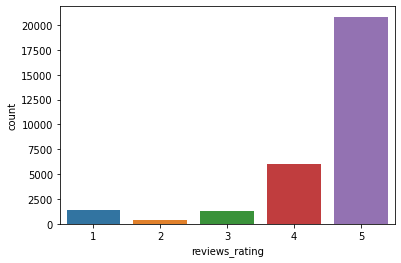

In [12]:
# lets visualize reviews_rating column on countplot
sns.countplot(ratings['reviews_rating'])
plt.show()

most of them are 5/5 ratings which tells there are more happy customers. we have one column in ratings reviews_didPurchase, means did customer got the product or not. It also tell us that it is a fake review. lets check.

In [13]:
# Let's check how many customers did purchase the product actually who has given reviews
ratings['reviews_didPurchase'].value_counts().sort_values(ascending=False)

False    14498
True      1434
Name: reviews_didPurchase, dtype: int64

In [14]:
# Missing entries in reviews_didPurchase column
ratings['reviews_didPurchase'].isnull().sum()

14068

In [15]:
print('total rows: ',ratings.shape[0])
print('missing reviews: 14068' )
print('total fake reviews : 14498'  )
print('genuine reviews: 1434')

total rows:  30000
missing reviews: 14068
total fake reviews : 14498
genuine reviews: 1434


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


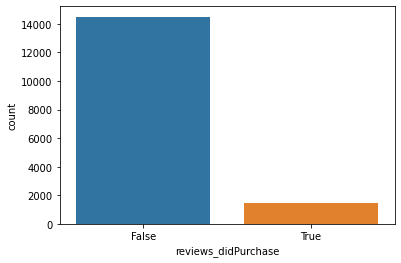

In [16]:
# Let's visualize column reviews_didPurchase on countplot
sns.countplot(ratings['reviews_didPurchase'])
plt.show()

In [17]:
# Lets check how many unique manufacturers are there
len(ratings['manufacturer'].unique())
# Total 228 unique manufacturers are there

228

In [18]:
# Lets check from how many cities customers have provided ratings
len(ratings['reviews_userCity'].unique())

978

In [19]:
# Total no. of provinces to provide ratings
len(ratings['reviews_userProvince'].unique())

43

In [20]:
# Total unique brands in dataset ratings
len(ratings['brand'].unique())

214

In [21]:
# No. of unique categories under ratings dataset
len(ratings['categories'].unique())

270

In [22]:
# Top 5 categories on value counts
ratings['categories'].value_counts().sort_values(ascending=False)[:5]
# under each category there are multiple categories

Household Essentials,Cleaning Supplies,Kitchen Cleaners,Cleaning Wipes,All-Purpose Cleaners,Health & Household,Household Supplies,Household Cleaning,Ways To Shop,Classroom Essentials,Featured Brands,Home And Storage & Org,Clorox,Glass Cleaners,Surface Care & Protection,Business & Industrial,Cleaning & Janitorial Supplies,Cleaners & Disinfectants,Cleaning Wipes & Pads,Cleaning Solutions,Housewares,Target Restock,Food & Grocery,Paper Goods,Wipes,All Purpose Cleaners    8545
Movies, Music & Books,Movies,Action & Adventure,Movies & Music,Movies & TV Shows,Frys                                                                                                                                                                                                                                                                                                                                                                                                   3325
Household Chemicals,Household Cleaners,Bath & 

In [23]:
# Lets check Target variable user_sentiment for class imbalance
ratings['user_sentiment'].value_counts(normalize=True)

Positive    0.887763
Negative    0.112237
Name: user_sentiment, dtype: float64

In [24]:
# Lets see an example of reviews_text
ratings['reviews_text'][0]

"i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy."

#### 1.2 Data Cleaning

In [25]:
# Let's convert all text columns in lower case
ratings['reviews_text'] = ratings['reviews_text'].str.lower()
ratings['reviews_title'] = ratings['reviews_title'].str.lower()
ratings['reviews_userCity'] = ratings['reviews_userCity'].str.lower()
ratings['reviews_userProvince'] = ratings['reviews_userProvince'].str.lower()

In [26]:
# Let's concatenate review_title and review_text to create a new column feedback
ratings['feedback'] = ratings['reviews_title'] + ' ' + ratings['reviews_text']
ratings.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment,feedback
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,just awesome,los angeles,NaN,joshua,Positive,just awesome i love this album. it's very good...
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,good flavor. this review was collected as part...,good,NaN,NaN,dorothy w,Positive,good good flavor. this review was collected as...
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,good flavor.,good,NaN,NaN,dorothy w,Positive,good good flavor.
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,i read through the reviews on here before look...,disappointed,NaN,NaN,rebecca,Negative,disappointed i read through the reviews on her...
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,my husband bought this gel for us. the gel cau...,irritation,NaN,NaN,walker557,Negative,irritation my husband bought this gel for us. ...


In [27]:
# We no longer need text and title columns as we have new column feedback
ratings.drop(['reviews_text', 'reviews_title'], axis = 1)

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment,feedback
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,los angeles,NaN,joshua,Positive,just awesome i love this album. it's very good...
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,NaN,NaN,dorothy w,Positive,good good flavor. this review was collected as...
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,NaN,NaN,dorothy w,Positive,good good flavor.
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,NaN,NaN,rebecca,Negative,disappointed i read through the reviews on her...
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,NaN,NaN,walker557,Negative,irritation my husband bought this gel for us. ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,AVpfW8y_LJeJML437ySW,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2017-01-23T00:00:00.000Z,False,True,5,NaN,NaN,laurasnchz,Positive,softness!! i got this conditioner with influen...
29996,AVpfW8y_LJeJML437ySW,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2017-01-27T00:00:00.000Z,False,True,5,NaN,NaN,scarlepadilla,Positive,"i love it i love it , i received this for revi..."
29997,AVpfW8y_LJeJML437ySW,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2017-01-21T00:00:00.000Z,False,True,5,NaN,NaN,liviasuexo,Positive,hair is so smooth after use first of all i lov...
29998,AVpfW8y_LJeJML437ySW,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2017-01-11T00:00:00.000Z,False,True,5,NaN,NaN,ktreed95,Positive,perfect for my oily hair! i received this thro...


In [28]:
## Let's check for missing values in columns
ratings.isnull().sum()

id                          0
brand                       0
categories                  0
manufacturer              141
name                        0
reviews_date               46
reviews_didPurchase     14068
reviews_doRecommend      2570
reviews_rating              0
reviews_text                0
reviews_title             190
reviews_userCity        28071
reviews_userProvince    29830
reviews_username           63
user_sentiment              1
feedback                  190
dtype: int64

#### 1.3 Text Preprocessing

In [29]:
## Converting feedback column into string type
ratings['feedback'] = ratings['feedback'].astype(str)

In [30]:
# Removing punctuations from feedback column

def identify_tokens(row):
    review = row['feedback']
    tokens = nltk.word_tokenize(review)
    # taken only words (not punctuation)
    token_words = [w for w in tokens if w.isalpha()]
    return token_words

ratings['feedback'] = ratings.apply(identify_tokens, axis=1)
ratings.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment,feedback
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,just awesome,los angeles,NaN,joshua,Positive,"[just, awesome, i, love, this, album, it, very..."
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,good flavor. this review was collected as part...,good,NaN,NaN,dorothy w,Positive,"[good, good, flavor, this, review, was, collec..."
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,good flavor.,good,NaN,NaN,dorothy w,Positive,"[good, good, flavor]"
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,i read through the reviews on here before look...,disappointed,NaN,NaN,rebecca,Negative,"[disappointed, i, read, through, the, reviews,..."
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,my husband bought this gel for us. the gel cau...,irritation,NaN,NaN,walker557,Negative,"[irritation, my, husband, bought, this, gel, f..."


In [31]:
# Removing stop words from feedback column
stops = set(stopwords.words("english"))                  

def remove_stops(row):
    my_list = row['feedback']
    meaningful_words = [w for w in my_list if not w in stops]
    return (meaningful_words)

ratings['feedback'] = ratings.apply(remove_stops, axis=1)
ratings.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment,feedback
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,just awesome,los angeles,NaN,joshua,Positive,"[awesome, love, album, good, hip, hop, side, c..."
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,good flavor. this review was collected as part...,good,NaN,NaN,dorothy w,Positive,"[good, good, flavor, review, collected, part, ..."
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,good flavor.,good,NaN,NaN,dorothy w,Positive,"[good, good, flavor]"
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,i read through the reviews on here before look...,disappointed,NaN,NaN,rebecca,Negative,"[disappointed, read, reviews, looking, buying,..."
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,my husband bought this gel for us. the gel cau...,irritation,NaN,NaN,walker557,Negative,"[irritation, husband, bought, gel, us, gel, ca..."


In [32]:
# Applying Stemming on feedback column using Porter Stemmer
stemmer = PorterStemmer()
def stem_list(row):
    my_list = row['feedback']
    stemmed_list = [stemmer.stem(word) for word in my_list]
    return (stemmed_list)

ratings['feedback_stem'] = ratings.apply(stem_list, axis=1)
ratings.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment,feedback,feedback_stem
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,just awesome,los angeles,NaN,joshua,Positive,"[awesome, love, album, good, hip, hop, side, c...","[awesom, love, album, good, hip, hop, side, cu..."
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,good flavor. this review was collected as part...,good,NaN,NaN,dorothy w,Positive,"[good, good, flavor, review, collected, part, ...","[good, good, flavor, review, collect, part, pr..."
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,good flavor.,good,NaN,NaN,dorothy w,Positive,"[good, good, flavor]","[good, good, flavor]"
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,i read through the reviews on here before look...,disappointed,NaN,NaN,rebecca,Negative,"[disappointed, read, reviews, looking, buying,...","[disappoint, read, review, look, buy, one, cou..."
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,my husband bought this gel for us. the gel cau...,irritation,NaN,NaN,walker557,Negative,"[irritation, husband, bought, gel, us, gel, ca...","[irrit, husband, bought, gel, us, gel, caus, i..."


In [33]:
from nltk.stem import WordNetLemmatizer
#ratings['feedback'] = ratings['feedback'].astype(str)
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    return ([lemmatizer.lemmatize(word) for word in text])

ratings["feedback_lemma"] = ratings["feedback"].apply(lambda text: lemmatize_words(text))
ratings.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment,feedback,feedback_stem,feedback_lemma
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,just awesome,los angeles,NaN,joshua,Positive,"[awesome, love, album, good, hip, hop, side, c...","[awesom, love, album, good, hip, hop, side, cu...","[awesome, love, album, good, hip, hop, side, c..."
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,good flavor. this review was collected as part...,good,NaN,NaN,dorothy w,Positive,"[good, good, flavor, review, collected, part, ...","[good, good, flavor, review, collect, part, pr...","[good, good, flavor, review, collected, part, ..."
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,good flavor.,good,NaN,NaN,dorothy w,Positive,"[good, good, flavor]","[good, good, flavor]","[good, good, flavor]"
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,i read through the reviews on here before look...,disappointed,NaN,NaN,rebecca,Negative,"[disappointed, read, reviews, looking, buying,...","[disappoint, read, review, look, buy, one, cou...","[disappointed, read, review, looking, buying, ..."
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,my husband bought this gel for us. the gel cau...,irritation,NaN,NaN,walker557,Negative,"[irritation, husband, bought, gel, us, gel, ca...","[irrit, husband, bought, gel, us, gel, caus, i...","[irritation, husband, bought, gel, u, gel, cau..."


In [34]:


lemmatizer = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
def lemmatize_words(text):
    pos_tagged_text = nltk.pos_tag(text)
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

ratings["feedback_lemmatized"] = ratings["feedback_stem"].apply(lambda text: lemmatize_words(text))
ratings.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment,feedback,feedback_stem,feedback_lemma,feedback_lemmatized
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,just awesome,los angeles,NaN,joshua,Positive,"[awesome, love, album, good, hip, hop, side, c...","[awesom, love, album, good, hip, hop, side, cu...","[awesome, love, album, good, hip, hop, side, c...",awesom love album good hip hop side current po...
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,good flavor. this review was collected as part...,good,NaN,NaN,dorothy w,Positive,"[good, good, flavor, review, collected, part, ...","[good, good, flavor, review, collect, part, pr...","[good, good, flavor, review, collected, part, ...",good good flavor review collect part promot
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,good flavor.,good,NaN,NaN,dorothy w,Positive,"[good, good, flavor]","[good, good, flavor]","[good, good, flavor]",good good flavor
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,i read through the reviews on here before look...,disappointed,NaN,NaN,rebecca,Negative,"[disappointed, read, reviews, looking, buying,...","[disappoint, read, review, look, buy, one, cou...","[disappointed, read, review, looking, buying, ...",disappoint read review look buy one coupl lubr...
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,my husband bought this gel for us. the gel cau...,irritation,NaN,NaN,walker557,Negative,"[irritation, husband, bought, gel, us, gel, ca...","[irrit, husband, bought, gel, us, gel, caus, i...","[irritation, husband, bought, gel, u, gel, cau...",irrit husband buy gel u gel caus irrit felt li...


In [35]:
# from spellchecker import SpellChecker

# spell = SpellChecker()
# def correct_spellings(text):
#     corrected_text = []
#     misspelled_words = spell.unknown(text)
#     for word in text:
#         if word in misspelled_words:
#             corrected_text.append(spell.correction(word))
#         else:
#             corrected_text.append(word)
#     return " ".join(corrected_text)
        
# correct_spellings(ratings['feedback_lemmatized'])
# ratings.head()

In [36]:
print(ratings['feedback_lemmatized'][:5])
ratings = ratings.drop(['feedback', 'feedback_stem', 'feedback_lemma'], axis = 1)

0    awesom love album good hip hop side current po...
1          good good flavor review collect part promot
2                                     good good flavor
3    disappoint read review look buy one coupl lubr...
4    irrit husband buy gel u gel caus irrit felt li...
Name: feedback_lemmatized, dtype: object


In [37]:
# def rejoin_words(row):
#     my_list = row['feedback_lemmatized']
#     joined_words = ( " ".join(my_list))
#     return joined_words

# ratings['feedback'] = ratings.apply(rejoin_words, axis=1)

In [38]:
sentiments = {'Positive':1, 'Negative':0}
# Add sentiments to the data
ratings["user_sentiment"] = ratings["user_sentiment"].map(sentiments)


In [39]:
ratings = ratings[ratings['user_sentiment'].notna()]
ratings['user_sentiment'] = ratings['user_sentiment'].astype(int)
ratings.head()
#ratings.isnull().sum()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment,feedback_lemmatized
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,just awesome,los angeles,NaN,joshua,1,awesom love album good hip hop side current po...
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,good flavor. this review was collected as part...,good,NaN,NaN,dorothy w,1,good good flavor review collect part promot
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,good flavor.,good,NaN,NaN,dorothy w,1,good good flavor
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,i read through the reviews on here before look...,disappointed,NaN,NaN,rebecca,0,disappoint read review look buy one coupl lubr...
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,my husband bought this gel for us. the gel cau...,irritation,NaN,NaN,walker557,0,irrit husband buy gel u gel caus irrit felt li...


In [40]:
X = ratings['feedback_lemmatized']
Y = ratings['user_sentiment']

X.shape
#Y.shape


(29999,)

In [41]:

# Split the dataset into test and train
seed = 50 

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=seed)

In [42]:
## using TFIDF vectorizer for text data
word_vectorizer = TfidfVectorizer(
    strip_accents='unicode',    # Remove accents and perform other character normalization during the preprocessing step. 
    analyzer='word',            # Whether the feature should be made of word or character n-grams.
    token_pattern=r'\w{1,}',    # Regular expression denoting what constitutes a “token”, only used if analyzer == 'word'
    ngram_range=(1, 3))         # The lower and upper boundary of the range of n-values for different n-grams to be extra


In [43]:
## transforming the train and test datasets
X_train_transformed = word_vectorizer.fit_transform(X_train.tolist())
X_test_transformed = word_vectorizer.transform(X_test.tolist())
pickle.dump(word_vectorizer, open('tranform.pkl', 'wb'))

In [44]:
# # Print the shape of each dataset.
print('X_train_transformed', X_train_transformed.shape)
print('y_train', y_train.shape)
print('X_test_transformed', X_test_transformed.shape)
print('y_test', y_test.shape)

X_train_transformed (20999, 416962)
y_train (20999,)
X_test_transformed (9000, 416962)
y_test (9000,)


Model-1: Logistic Regression

1.1 using unsampled Data

In [45]:
# Build the Logistic Regression model 
import time
time1 = time.time()

logit = LogisticRegression()
logit.fit(X_train_transformed,y_train)
pickle.dump(logit, open('logit_model', 'wb'))
time_taken = time.time() - time1
print('Time Taken: {:.2f} seconds'.format(time_taken))

Time Taken: 6.47 seconds


In [46]:
y_pred = logit.predict(X_test_transformed)

In [47]:
# Confusion matrix 
from sklearn import metrics
confusion = metrics.confusion_matrix(y_test, y_pred)
print(confusion)

[[  63  951]
 [   5 7981]]


This result is telling us that 63+7981 correct predictions and 5+951 incorrect predictions

In [48]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))
## Precision is .9, Recall is .89 and F1-Score is 0.85

              precision    recall  f1-score   support

           0       0.93      0.06      0.12      1014
           1       0.89      1.00      0.94      7986

    accuracy                           0.89      9000
   macro avg       0.91      0.53      0.53      9000
weighted avg       0.90      0.89      0.85      9000



# Handling class imbalance through SMOTE technique

In [49]:
from imblearn.over_sampling import SMOTE

counter = Counter(y_train)
print('Before',counter)
# oversampling the train dataset using SMOTE
smt = SMOTE()
#X_train, y_train = smt.fit_resample(X_train, y_train)
X_train_sm, y_train_sm = smt.fit_resample(X_train_transformed, y_train)

counter = Counter(y_train_sm)
print('After',counter)

Before Counter({1: 18646, 0: 2353})


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


After Counter({0: 18646, 1: 18646})


In [50]:
# model = list()
# resample = list()
# precision = list()
# recall = list()
# F1score = list()
# AUCROC = list()

In [51]:
# def test_eval(clf_model, X_test, y_test, algo=None, sampling=None):
#     # Test set prediction
#     y_prob=clf_model.predict_proba(X_test)
#     y_pred=clf_model.predict(X_test)

#     print('Confusion Matrix')
#     print('='*60)
#     print(confusion_matrix(y_test,y_pred),"\n")
#     print('Classification Report')
#     print('='*60)
#     print(classification_report(y_test,y_pred),"\n")
#     print('AUC-ROC')
#     print('='*60)
#     print(roc_auc_score(y_test, y_prob[:,1]))
          
#     model.append(algo)
#     precision.append(precision_score(y_test,y_pred))
#     recall.append(recall_score(y_test,y_pred))
#     F1score.append(f1_score(y_test,y_pred))
#     AUCROC.append(roc_auc_score(y_test, y_prob[:,1]))
#     resample.append(sampling)

1.2. Logistic Regression using SMOTE Resampling

In [52]:
logit.fit(X_train_sm,y_train_sm)
pickle.dump(logit, open('logit_model_sm', 'wb'))

In [53]:
y_pred_sm = logit.predict(X_test_transformed)

In [54]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_sm))
## Precison is .9, Recall is 0.91 and F1-Score is 0.9 on sampled data

              precision    recall  f1-score   support

           0       0.59      0.55      0.57      1014
           1       0.94      0.95      0.95      7986

    accuracy                           0.91      9000
   macro avg       0.77      0.75      0.76      9000
weighted avg       0.90      0.91      0.90      9000



Model-2: Random Forest using unsampled data

> Indented block



In [55]:
estimators = [2,10,30,50,100]
# Maximum number of depth in each tree:
max_depth = [i for i in range(5,16,2)]
# Minimum number of samples to consider to split a node:
min_samples_split = [2, 5, 10, 15, 20, 50, 100]
# Minimum number of samples to consider at each leaf node:
min_samples_leaf = [1, 2, 5]

In [56]:
cv = StratifiedKFold(n_splits=5, random_state=100, shuffle=True)

In [57]:
rf_model = RandomForestClassifier()

rf_params={'n_estimators':estimators,
           'max_depth':max_depth,
           'min_samples_split':min_samples_split}

clf_RF = RandomizedSearchCV(rf_model, rf_params, cv=cv, scoring='roc_auc', n_jobs=-1, n_iter=20, verbose=2)
clf_RF.fit(X_train_transformed, y_train)
clf_RF.best_estimator_
pickle.dump(clf_RF, open('RF_model', 'wb'))

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.7min finished


In [58]:
y_pred_rf = clf_RF.predict(X_test_transformed)

In [59]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_rf))
## Precision is 0.79, Recall is 0.89 and F1-score is 0.83 using Random Forest

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1014
           1       0.89      1.00      0.94      7986

    accuracy                           0.89      9000
   macro avg       0.44      0.50      0.47      9000
weighted avg       0.79      0.89      0.83      9000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2.2 Random Forest with Sampled Data

In [60]:
rf_model = RandomForestClassifier()

rf_params={'n_estimators':estimators,
           'max_depth':max_depth,
           'min_samples_split':min_samples_split}

clf_RF = RandomizedSearchCV(rf_model, rf_params, cv=cv, scoring='roc_auc', n_jobs=-1, n_iter=20, verbose=2)
clf_RF.fit(X_train_sm, y_train_sm)
clf_RF.best_estimator_
pickle.dump(clf_RF, open('RF_model_sm', 'wb'))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.9min finished


In [61]:
y_pred_rfsm = clf_RF.predict(X_test_transformed)

In [62]:
print(classification_report(y_test, y_pred_rfsm))
## Precision is 0.86, Recall is 0.87 and F1-score is 0.86 using sampled data on Random Forest

              precision    recall  f1-score   support

           0       0.39      0.29      0.34      1014
           1       0.91      0.94      0.93      7986

    accuracy                           0.87      9000
   macro avg       0.65      0.62      0.63      9000
weighted avg       0.85      0.87      0.86      9000



### 3.1 XGBoost on unsampled data

In [63]:
# xgb_model = xgb.XGBClassifier()

# parameters = {'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
#               'max_depth': [2, 4, 6, 8, 10],
#               'min_child_weight': [3, 4, 5, 7, 9],
#               'n_estimators': [50, 100, 125, 150, 170, 200]}

# scorer = metrics.make_scorer(metrics.roc_auc_score,
#                              greater_is_better=True,
#                              needs_proba=True,
#                              needs_threshold=False)

# clf_xgb = model_selection.GridSearchCV(estimator=xgb_model,
#                                        param_grid=parameters,
#                                        n_jobs=-1,
#                                        cv=3,
#                                        scoring=scorer,
#                                        refit=True)


# clf_xgb.fit(X_train_transformed, y_train)

# fit model on training data
model = xgb.XGBClassifier()
model.fit(X_train_transformed, y_train)
pickle.dump(model, open('xgb_model', 'wb'))

In [64]:
# make predictions for test data
y_pred_xgb = model.predict(X_test_transformed)

In [65]:
print(classification_report(y_test, y_pred_xgb))
## Precision is 0.89, Recall is 0.9 and F1-Score is 0.86 on XGBoost

              precision    recall  f1-score   support

           0       0.81      0.11      0.19      1014
           1       0.90      1.00      0.94      7986

    accuracy                           0.90      9000
   macro avg       0.86      0.55      0.57      9000
weighted avg       0.89      0.90      0.86      9000



### 3.2 XGBoost With Sampling Data

In [66]:
# fit model on training data
model_sm = xgb.XGBClassifier()
model_sm.fit(X_train_sm, y_train_sm)
pickle.dump(model_sm, open('xgb_model_sm', 'wb'))

In [67]:
# make predictions for test data
y_pred_xgbsm = model_sm.predict(X_test_transformed)

In [68]:
print(classification_report(y_test, y_pred_xgbsm))
## Precision is 0.88, Recall is 0.85 and F1-Score is 0.86 on sampled data using with XGBoost

              precision    recall  f1-score   support

           0       0.39      0.55      0.46      1014
           1       0.94      0.89      0.92      7986

    accuracy                           0.85      9000
   macro avg       0.67      0.72      0.69      9000
weighted avg       0.88      0.85      0.86      9000



	                                   precision	recall	f1-score
Logistice Regression unsampled	           0.9	    0.89	  0.85

Logistice Regression sampled	             0.9	    0.9	    0.9

Random Forest unsampled	                   0.79	    0.89	  0.83

Random Forest sampled	                     0.86	    0.87  	0.86

XGBoost unsampled	                         0.89	    0.9	    0.86

XGBoost sampled	                           0.88	    0.85	  0.86


Looking at the above statistics we think that Logistic Regression with sampled data is giving best results and we can choose this to improve recommendation system

In [69]:
# # X_train_transformed.toarray()
# nbclf = naive_bayes.MultinomialNB()
# nbclf.fit(X_train_transformed, y_train)
# pickle.dump(nbclf, open('nb_model', 'wb'))

In [70]:
# y_pred_nb = nbclf.predict(X_test_transformed)

In [71]:
# print(classification_report(y_test,y_pred_nb))

In [72]:
# nbclf_sm = naive_bayes.MultinomialNB()
# nbclf_sm.fit(X_train_sm, y_train_sm)
# pickle.dump(nbclf_sm, open('nb_model_sm', 'wb'))

In [73]:
# y_pred_nbsm = nbclf_sm.predict(X_test)

In [74]:
# print(classification_report(y_test,y_pred_nbsm))

In [75]:
ratings.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment,feedback_lemmatized
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,just awesome,los angeles,NaN,joshua,1,awesom love album good hip hop side current po...
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,good flavor. this review was collected as part...,good,NaN,NaN,dorothy w,1,good good flavor review collect part promot
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,good flavor.,good,NaN,NaN,dorothy w,1,good good flavor
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,i read through the reviews on here before look...,disappointed,NaN,NaN,rebecca,0,disappoint read review look buy one coupl lubr...
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,my husband bought this gel for us. the gel cau...,irritation,NaN,NaN,walker557,0,irrit husband buy gel u gel caus irrit felt li...


In [76]:

# User Based collaborative filtering
# Pivot the train ratings' dataset into matrix format in which columns are products and the rows are user names.

from sklearn.model_selection import train_test_split
train, test = train_test_split(ratings, test_size=0.30, random_state=31)

train.head()
print(train.shape)
print(test.shape)

train.head()
df_pivot = pd.pivot_table(train,
    index='reviews_username',
    columns='name',
    values='reviews_rating'
).fillna(0)

df_pivot.head()


(20999, 16)
(9000, 16)


name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,Annie's Homegrown Deluxe Elbows & Four Cheese Sauce,Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz",Avery174 11-1/4 X 9-1/4 Index Maker Extra Wide Label Dividers With 5 Tab - Clear (5 Sets Per Pack),"Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL","Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Barielle Nail Rebuilding Protein,Baxter Of California Cream Pomade,"Beanitos Bean Chips, Simply Pinto Bean",Bedtime Originals Pinkie Musical Mobile,"Ben & Jerry's Coffee, Coffee Buzzbuzzbuzz! Ice Cream, Pint","Better Built 74010862 Bet74010862 60In Crossover Two Lid, Deep, Truck Tool Box",Bi-O-kleen Spray & Wipe All Purpose Cleaner,Bilbao Nightstand Gray Oak - South Shore,Bill Glor Gaither - Church In The Wildwood (cd),Bisquick Original Pancake And Baking Mix - 40oz,Black Front Loading Frame Set (8.5x11) Set Of 12,Black Sister's Revenge (dvd),Blue Anchor Design Throw Pillow (18x18) - Rizzy Home,Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 sheets",Bumble Bee Solid White Albacore In Water - 5 Oz,"Burt's Bees Lip Shimmer, Raisin","Burt's Bees Lip Shimmer, Watermelon",...,Spam Single Classic,Stacy's Garden Veggie Medley Pita Chips,Stacy's Simply Naked Bagel Chips,Stander Pt Bedcane - Bed Handle,Starbucks Iced Expresso Classics Vanilla Latte Coffee Beverage - 40oz,Starbucks153 Doubleshot Protein Coffee - 11 Fl Oz,Stargate (ws) (ultimate Edition) (director's Cut) (dvdvideo),"Storkcraft Tuscany Glider and Ottoman, Beige Cushions, Espresso Finish","Suave Professionals Hair Conditioner, Sleek","Super Poligrip Denture Adhesive Cream, Ultra Fresh - 2.4 Oz",Switchmas (dvd),Tai Pei Sweet & Sour Chicken,The Honest Company Laundry Detergent,The Resident Evil Collection 5 Discs (blu-Ray),The Script - No Sound Without Silence (cd),"The Seaweed Bath Co. Argan Conditioner, Smoothing Citrus",There's Something About Mary (dvd),Tostitos Bite Size Tortilla Chips,Tostitos Simply Blue Corn Tortilla Chips,Toy Story Kids' Woody Accessory Kit,Tramontina Ceramica 10 Piece Cookware Set - Red,"Tree Hut Shea Body Butters, Coconut Lime, 7 oz",Trend Lab Park Nursing Cover - Paisley,Tresemme Kertatin Smooth Infusing Conditioning,Various - Red Hot Blue:Tribute To Cole Porter (cd),Various Artists - Choo Choo Soul (cd),Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [77]:
# """### Creating dummy train & dummy test dataset
# These dataset will be used for prediction 
# - Dummy train will be used later for prediction of the products which has not been rated by the user. To ignore the products rated by the user, we will mark it as 0 during prediction. The products not rated by user is marked as 1 for prediction in dummy train dataset. 

# - Dummy test will be used for evaluation. To evaluate, we will only make prediction on the products rated by the user. So, this is marked as 1. This is just opposite of dummy_train.
# """

# Copy the train dataset into dummy_train
dummy_train = train.copy()

dummy_train.head()

# The products not rated by user is marked as 1 for prediction. 
dummy_train['reviews_rating'] = dummy_train['reviews_rating'].apply(lambda x: 0 if x>=1 else 1)


In [78]:
# Convert the dummy train dataset into matrix format.

dummy_train = pd.pivot_table(dummy_train,
    index='reviews_username',
    columns='name',
    values='reviews_rating'
).fillna(1)

dummy_train.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,Annie's Homegrown Deluxe Elbows & Four Cheese Sauce,Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz",Avery174 11-1/4 X 9-1/4 Index Maker Extra Wide Label Dividers With 5 Tab - Clear (5 Sets Per Pack),"Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL","Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Barielle Nail Rebuilding Protein,Baxter Of California Cream Pomade,"Beanitos Bean Chips, Simply Pinto Bean",Bedtime Originals Pinkie Musical Mobile,"Ben & Jerry's Coffee, Coffee Buzzbuzzbuzz! Ice Cream, Pint","Better Built 74010862 Bet74010862 60In Crossover Two Lid, Deep, Truck Tool Box",Bi-O-kleen Spray & Wipe All Purpose Cleaner,Bilbao Nightstand Gray Oak - South Shore,Bill Glor Gaither - Church In The Wildwood (cd),Bisquick Original Pancake And Baking Mix - 40oz,Black Front Loading Frame Set (8.5x11) Set Of 12,Black Sister's Revenge (dvd),Blue Anchor Design Throw Pillow (18x18) - Rizzy Home,Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 sheets",Bumble Bee Solid White Albacore In Water - 5 Oz,"Burt's Bees Lip Shimmer, Raisin","Burt's Bees Lip Shimmer, Watermelon",...,Spam Single Classic,Stacy's Garden Veggie Medley Pita Chips,Stacy's Simply Naked Bagel Chips,Stander Pt Bedcane - Bed Handle,Starbucks Iced Expresso Classics Vanilla Latte Coffee Beverage - 40oz,Starbucks153 Doubleshot Protein Coffee - 11 Fl Oz,Stargate (ws) (ultimate Edition) (director's Cut) (dvdvideo),"Storkcraft Tuscany Glider and Ottoman, Beige Cushions, Espresso Finish","Suave Professionals Hair Conditioner, Sleek","Super Poligrip Denture Adhesive Cream, Ultra Fresh - 2.4 Oz",Switchmas (dvd),Tai Pei Sweet & Sour Chicken,The Honest Company Laundry Detergent,The Resident Evil Collection 5 Discs (blu-Ray),The Script - No Sound Without Silence (cd),"The Seaweed Bath Co. Argan Conditioner, Smoothing Citrus",There's Something About Mary (dvd),Tostitos Bite Size Tortilla Chips,Tostitos Simply Blue Corn Tortilla Chips,Toy Story Kids' Woody Accessory Kit,Tramontina Ceramica 10 Piece Cookware Set - Red,"Tree Hut Shea Body Butters, Coconut Lime, 7 oz",Trend Lab Park Nursing Cover - Paisley,Tresemme Kertatin Smooth Infusing Conditioning,Various - Red Hot Blue:Tribute To Cole Porter (cd),Various Artists - Choo Choo Soul (cd),Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00dog3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0

In [79]:
# """**Cosine Similarity**

# Cosine Similarity is a measurement that quantifies the similarity between two vectors [Which is Rating Vector in this case] 

# **Adjusted Cosine**

# Adjusted cosine similarity is a modified version of vector-based similarity where we incorporate the fact that different users have different ratings schemes. In other words, some users might rate items highly in general, and others might give items lower ratings as a preference. To handle this nature from rating given by user , we subtract average ratings for each user from each user's rating for different products.

# # User Similarity Matrix

# ## Using Cosine Similarity

from sklearn.metrics.pairwise import pairwise_distances

# Creating the User Similarity Matrix using pairwise_distance function.

user_correlation = 1 - pairwise_distances(df_pivot, metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)
user_correlation.shape

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


(18255, 18255)

In [80]:
## Using adjusted Cosine

### Here, we are not removing the NaN values and calculating the mean only for the products rated by the user


# Create a user-product matrix.
df_pivot = pd.pivot_table(train,
    index='reviews_username',
    columns='name',
    values='reviews_rating'
)

df_pivot.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,Annie's Homegrown Deluxe Elbows & Four Cheese Sauce,Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz",Avery174 11-1/4 X 9-1/4 Index Maker Extra Wide Label Dividers With 5 Tab - Clear (5 Sets Per Pack),"Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL","Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Barielle Nail Rebuilding Protein,Baxter Of California Cream Pomade,"Beanitos Bean Chips, Simply Pinto Bean",Bedtime Originals Pinkie Musical Mobile,"Ben & Jerry's Coffee, Coffee Buzzbuzzbuzz! Ice Cream, Pint","Better Built 74010862 Bet74010862 60In Crossover Two Lid, Deep, Truck Tool Box",Bi-O-kleen Spray & Wipe All Purpose Cleaner,Bilbao Nightstand Gray Oak - South Shore,Bill Glor Gaither - Church In The Wildwood (cd),Bisquick Original Pancake And Baking Mix - 40oz,Black Front Loading Frame Set (8.5x11) Set Of 12,Black Sister's Revenge (dvd),Blue Anchor Design Throw Pillow (18x18) - Rizzy Home,Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 sheets",Bumble Bee Solid White Albacore In Water - 5 Oz,"Burt's Bees Lip Shimmer, Raisin","Burt's Bees Lip Shimmer, Watermelon",...,Spam Single Classic,Stacy's Garden Veggie Medley Pita Chips,Stacy's Simply Naked Bagel Chips,Stander Pt Bedcane - Bed Handle,Starbucks Iced Expresso Classics Vanilla Latte Coffee Beverage - 40oz,Starbucks153 Doubleshot Protein Coffee - 11 Fl Oz,Stargate (ws) (ultimate Edition) (director's Cut) (dvdvideo),"Storkcraft Tuscany Glider and Ottoman, Beige Cushions, Espresso Finish","Suave Professionals Hair Conditioner, Sleek","Super Poligrip Denture Adhesive Cream, Ultra Fresh - 2.4 Oz",Switchmas (dvd),Tai Pei Sweet & Sour Chicken,The Honest Company Laundry Detergent,The Resident Evil Collection 5 Discs (blu-Ray),The Script - No Sound Without Silence (cd),"The Seaweed Bath Co. Argan Conditioner, Smoothing Citrus",There's Something About Mary (dvd),Tostitos Bite Size Tortilla Chips,Tostitos Simply Blue Corn Tortilla Chips,Toy Story Kids' Woody Accessory Kit,Tramontina Ceramica 10 Piece Cookware Set - Red,"Tree Hut Shea Body Butters, Coconut Lime, 7 oz",Trend Lab Park Nursing Cover - Paisley,Tresemme Kertatin Smooth Infusing Conditioning,Various - Red Hot Blue:Tribute To Cole Porter (cd),Various Artists - Choo Choo Soul (cd),Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00dog3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [81]:
### Normalising the rating of the product for each user around 0 mean"""

mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T
df_subtracted.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,Annie's Homegrown Deluxe Elbows & Four Cheese Sauce,Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz",Avery174 11-1/4 X 9-1/4 Index Maker Extra Wide Label Dividers With 5 Tab - Clear (5 Sets Per Pack),"Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL","Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Barielle Nail Rebuilding Protein,Baxter Of California Cream Pomade,"Beanitos Bean Chips, Simply Pinto Bean",Bedtime Originals Pinkie Musical Mobile,"Ben & Jerry's Coffee, Coffee Buzzbuzzbuzz! Ice Cream, Pint","Better Built 74010862 Bet74010862 60In Crossover Two Lid, Deep, Truck Tool Box",Bi-O-kleen Spray & Wipe All Purpose Cleaner,Bilbao Nightstand Gray Oak - South Shore,Bill Glor Gaither - Church In The Wildwood (cd),Bisquick Original Pancake And Baking Mix - 40oz,Black Front Loading Frame Set (8.5x11) Set Of 12,Black Sister's Revenge (dvd),Blue Anchor Design Throw Pillow (18x18) - Rizzy Home,Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 sheets",Bumble Bee Solid White Albacore In Water - 5 Oz,"Burt's Bees Lip Shimmer, Raisin","Burt's Bees Lip Shimmer, Watermelon",...,Spam Single Classic,Stacy's Garden Veggie Medley Pita Chips,Stacy's Simply Naked Bagel Chips,Stander Pt Bedcane - Bed Handle,Starbucks Iced Expresso Classics Vanilla Latte Coffee Beverage - 40oz,Starbucks153 Doubleshot Protein Coffee - 11 Fl Oz,Stargate (ws) (ultimate Edition) (director's Cut) (dvdvideo),"Storkcraft Tuscany Glider and Ottoman, Beige Cushions, Espresso Finish","Suave Professionals Hair Conditioner, Sleek","Super Poligrip Denture Adhesive Cream, Ultra Fresh - 2.4 Oz",Switchmas (dvd),Tai Pei Sweet & Sour Chicken,The Honest Company Laundry Detergent,The Resident Evil Collection 5 Discs (blu-Ray),The Script - No Sound Without Silence (cd),"The Seaweed Bath Co. Argan Conditioner, Smoothing Citrus",There's Something About Mary (dvd),Tostitos Bite Size Tortilla Chips,Tostitos Simply Blue Corn Tortilla Chips,Toy Story Kids' Woody Accessory Kit,Tramontina Ceramica 10 Piece Cookware Set - Red,"Tree Hut Shea Body Butters, Coconut Lime, 7 oz",Trend Lab Park Nursing Cover - Paisley,Tresemme Kertatin Smooth Infusing Conditioning,Various - Red Hot Blue:Tribute To Cole Porter (cd),Various Artists - Choo Choo Soul (cd),Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00dog3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [82]:
### Finding cosine similarity"""

from sklearn.metrics.pairwise import pairwise_distances

# Creating the User Similarity Matrix using pairwise_distance function.
user_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [83]:
## Prediction - User User

#Doing the prediction for the users which are positively related with other users, and not the users which are negatively related as we are interested in the users which are more similar to the current users. So, ignoring the correlation for values less than 0.

user_correlation[user_correlation<0]=0
user_correlation

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [84]:
##Rating predicted by the user (for products rated as well as not rated) is the weighted sum of correlation with the product rating (as present in the rating dataset). """

user_predicted_ratings = np.dot(user_correlation, df_pivot.fillna(0))
user_predicted_ratings

user_predicted_ratings.shape


(18255, 251)

In [85]:
##Since we are interested only in the products not rated by the user, we will ignore the products rated by the user by making it zero

user_final_rating = np.multiply(user_predicted_ratings,dummy_train)
user_final_rating.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,Annie's Homegrown Deluxe Elbows & Four Cheese Sauce,Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz",Avery174 11-1/4 X 9-1/4 Index Maker Extra Wide Label Dividers With 5 Tab - Clear (5 Sets Per Pack),"Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL","Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Barielle Nail Rebuilding Protein,Baxter Of California Cream Pomade,"Beanitos Bean Chips, Simply Pinto Bean",Bedtime Originals Pinkie Musical Mobile,"Ben & Jerry's Coffee, Coffee Buzzbuzzbuzz! Ice Cream, Pint","Better Built 74010862 Bet74010862 60In Crossover Two Lid, Deep, Truck Tool Box",Bi-O-kleen Spray & Wipe All Purpose Cleaner,Bilbao Nightstand Gray Oak - South Shore,Bill Glor Gaither - Church In The Wildwood (cd),Bisquick Original Pancake And Baking Mix - 40oz,Black Front Loading Frame Set (8.5x11) Set Of 12,Black Sister's Revenge (dvd),Blue Anchor Design Throw Pillow (18x18) - Rizzy Home,Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 sheets",Bumble Bee Solid White Albacore In Water - 5 Oz,"Burt's Bees Lip Shimmer, Raisin","Burt's Bees Lip Shimmer, Watermelon",...,Spam Single Classic,Stacy's Garden Veggie Medley Pita Chips,Stacy's Simply Naked Bagel Chips,Stander Pt Bedcane - Bed Handle,Starbucks Iced Expresso Classics Vanilla Latte Coffee Beverage - 40oz,Starbucks153 Doubleshot Protein Coffee - 11 Fl Oz,Stargate (ws) (ultimate Edition) (director's Cut) (dvdvideo),"Storkcraft Tuscany Glider and Ottoman, Beige Cushions, Espresso Finish","Suave Professionals Hair Conditioner, Sleek","Super Poligrip Denture Adhesive Cream, Ultra Fresh - 2.4 Oz",Switchmas (dvd),Tai Pei Sweet & Sour Chicken,The Honest Company Laundry Detergent,The Resident Evil Collection 5 Discs (blu-Ray),The Script - No Sound Without Silence (cd),"The Seaweed Bath Co. Argan Conditioner, Smoothing Citrus",There's Something About Mary (dvd),Tostitos Bite Size Tortilla Chips,Tostitos Simply Blue Corn Tortilla Chips,Toy Story Kids' Woody Accessory Kit,Tramontina Ceramica 10 Piece Cookware Set - Red,"Tree Hut Shea Body Butters, Coconut Lime, 7 oz",Trend Lab Park Nursing Cover - Paisley,Tresemme Kertatin Smooth Infusing Conditioning,Various - Red Hot Blue:Tribute To Cole Porter (cd),Various Artists - Choo Choo Soul (cd),Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [86]:
### Finding the top 20 recommendation for the *user*"""

# Take the user ID as input.
user_input = str(input("Enter your user name"))
print(user_input)

user_final_rating.head(7)

d = user_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
d

Enter your user namejoshua
joshua


name
Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd                                  15.419960
Tostitos Bite Size Tortilla Chips                                                                 4.112350
My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital)                                              4.008827
Mike Dave Need Wedding Dates (dvd + Digital)                                                      3.795624
Windex Original Glass Cleaner Refill 67.6oz (2 Liter)                                             3.476007
Clorox Disinfecting Bathroom Cleaner                                                              2.927700
Chester's Cheese Flavored Puffcorn Snacks                                                         2.927700
Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo)                                     2.886751
Vicks Vaporub, Regular, 3.53oz                                                                    2.886751
Planes: Fire Rescue (2 Discs) (i

In [87]:
#Mapping with product name 
#prod_mapping = pd.DataFrame(ratings.categories, ratings.name)

prod_mapping.head()

d = pd.merge(d,prod_mapping,left_on='name',right_on='name', how = 'left')
d.head()

,joshua,categories
name,,
Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,15.41996,NaN
Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,15.41996,NaN
Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,15.41996,NaN
Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,15.41996,NaN
Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,15.41996,NaN


In [88]:
#Evaluation will we same as you have seen above for the prediction. The only difference being, you will evaluate for the product already rated by the user insead of predicting it for the product not rated by the user.


# Find out the common users of test and train dataset.
common = test[test.reviews_username.isin(train.reviews_username)]
common.shape

common.head()


,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment,feedback_lemmatized
20458,AVpfJP1C1cnluZ0-e3Xy,Clorox,"Household Chemicals,Household Cleaners,Bath & ...",AmazonUs/CLOO7,Clorox Disinfecting Bathroom Cleaner,2012-01-26T00:00:00.000Z,False,True,5,the product is wonderful in the shower and the...,works great in the shower,NaN,NaN,cleansmells,1,work great shower product wonder shower sink r...
28827,AVpfW8y_LJeJML437ySW,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2017-01-14T10:30:41.000Z,NaN,NaN,1,"i didn't not like this product, i received it ...",not very hydrating,buffalo,NaN,kelly4729,1,hydrat like product receiv influenst felt like...
9617,AVpf3VOfilAPnD_xjpun,Clorox,"Household Essentials,Cleaning Supplies,Kitchen...",Clorox,Clorox Disinfecting Wipes Value Pack Scented 1...,2012-01-27T14:18:57.000Z,NaN,True,5,"i love the wipes i use them all over my house,...",overall grat product,middletown,NaN,earreaga,1,overal grat product love wipe use hous smell good
9986,AVpf3VOfilAPnD_xjpun,Clorox,"Household Essentials,Cleaning Supplies,Kitchen...",Clorox,Clorox Disinfecting Wipes Value Pack Scented 1...,2015-02-21T00:00:00.000Z,False,True,5,i love the ease of use of the wipes. they clea...,love these wipes,NaN,NaN,ncmom2224,1,love wipe love ea use wipe clean well nice sme...
27636,AVpfRTh1ilAPnD_xYic2,Disney,"Movies, Music & Books,Movies,Kids' & Family,Wa...",Walt Disney,Planes: Fire Rescue (2 Discs) (includes Digita...,2014-12-05T00:00:00.000Z,NaN,True,5,"a much more interesting movie than ""planes"" or...",a fun movie with some messages,NaN,NaN,raymond,1,fun movi messag much interest movi plane chara...


In [89]:
# convert into the user-product matrix.
common_user_based_matrix = common.pivot_table(index='reviews_username', columns='name', values='reviews_rating')


In [90]:
# Convert the user_correlation matrix into dataframe.
user_correlation_df = pd.DataFrame(user_correlation)

df_subtracted.head(1)

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,Annie's Homegrown Deluxe Elbows & Four Cheese Sauce,Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz",Avery174 11-1/4 X 9-1/4 Index Maker Extra Wide Label Dividers With 5 Tab - Clear (5 Sets Per Pack),"Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL","Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Barielle Nail Rebuilding Protein,Baxter Of California Cream Pomade,"Beanitos Bean Chips, Simply Pinto Bean",Bedtime Originals Pinkie Musical Mobile,"Ben & Jerry's Coffee, Coffee Buzzbuzzbuzz! Ice Cream, Pint","Better Built 74010862 Bet74010862 60In Crossover Two Lid, Deep, Truck Tool Box",Bi-O-kleen Spray & Wipe All Purpose Cleaner,Bilbao Nightstand Gray Oak - South Shore,Bill Glor Gaither - Church In The Wildwood (cd),Bisquick Original Pancake And Baking Mix - 40oz,Black Front Loading Frame Set (8.5x11) Set Of 12,Black Sister's Revenge (dvd),Blue Anchor Design Throw Pillow (18x18) - Rizzy Home,Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 sheets",Bumble Bee Solid White Albacore In Water - 5 Oz,"Burt's Bees Lip Shimmer, Raisin","Burt's Bees Lip Shimmer, Watermelon",...,Spam Single Classic,Stacy's Garden Veggie Medley Pita Chips,Stacy's Simply Naked Bagel Chips,Stander Pt Bedcane - Bed Handle,Starbucks Iced Expresso Classics Vanilla Latte Coffee Beverage - 40oz,Starbucks153 Doubleshot Protein Coffee - 11 Fl Oz,Stargate (ws) (ultimate Edition) (director's Cut) (dvdvideo),"Storkcraft Tuscany Glider and Ottoman, Beige Cushions, Espresso Finish","Suave Professionals Hair Conditioner, Sleek","Super Poligrip Denture Adhesive Cream, Ultra Fresh - 2.4 Oz",Switchmas (dvd),Tai Pei Sweet & Sour Chicken,The Honest Company Laundry Detergent,The Resident Evil Collection 5 Discs (blu-Ray),The Script - No Sound Without Silence (cd),"The Seaweed Bath Co. Argan Conditioner, Smoothing Citrus",There's Something About Mary (dvd),Tostitos Bite Size Tortilla Chips,Tostitos Simply Blue Corn Tortilla Chips,Toy Story Kids' Woody Accessory Kit,Tramontina Ceramica 10 Piece Cookware Set - Red,"Tree Hut Shea Body Butters, Coconut Lime, 7 oz",Trend Lab Park Nursing Cover - Paisley,Tresemme Kertatin Smooth Infusing Conditioning,Various - Red Hot Blue:Tribute To Cole Porter (cd),Various Artists - Choo Choo Soul (cd),Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00dog3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [91]:
user_correlation_df['reviews_username'] = df_subtracted.index
user_correlation_df.set_index('reviews_username',inplace=True)
user_correlation_df.head()



,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,18215,18216,18217,18218,18219,18220,18221,18222,18223,18224,18225,18226,18227,18228,18229,18230,18231,18232,18233,18234,18235,18236,18237,18238,18239,18240,18241,18242,18243,18244,18245,18246,18247,18248,18249,18250,18251,18252,18253,18254
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02dakota,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02deuce,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0325home,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [92]:
common.head(1)

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment,feedback_lemmatized
20458,AVpfJP1C1cnluZ0-e3Xy,Clorox,"Household Chemicals,Household Cleaners,Bath & ...",AmazonUs/CLOO7,Clorox Disinfecting Bathroom Cleaner,2012-01-26T00:00:00.000Z,False,True,5,the product is wonderful in the shower and the...,works great in the shower,NaN,NaN,cleansmells,1,work great shower product wonder shower sink r...


In [93]:
list_name = common.reviews_username.tolist()

user_correlation_df.columns = df_subtracted.index.tolist()


In [94]:
user_correlation_df_1 =  user_correlation_df[user_correlation_df.index.isin(list_name)]
user_correlation_df_1.shape


(1691, 18255)

In [95]:
user_correlation_df_2 = user_correlation_df_1.T[user_correlation_df_1.T.index.isin(list_name)]

user_correlation_df_3 = user_correlation_df_2.T


In [96]:
user_correlation_df_3.shape
user_correlation_df_3.head()


,00sab00,123charlie,1943,4djs,50cal,7inthenest,85lisa,aalyah,aaron,abbey,abby,abc,abcdef,abcgator,abigail,abismomy,acellacey,acg1,acjuarez08,actionaction,adam,adizzione,adma2,adriana9999,afwifey2003,agmt,aisha,aj,aj1135,ajackson75,ajay,ajcrossover11,ajune,akesler19,akhan,akporter84,alena125,alex,alexa86,alexis,...,viewer,viking80,vikki,vivi37,vivian,vivienne,vkay,vreal88,wally,wasabi42,watson28,weewee,wendy,wendy59,wendydarling,wernigcourtney,whythis,willy,wizard,wolf,wolverine,woohoo,woottos,woowoo,workingmomof1,worm,wowwie,wren113,xcoupon,xmom,yayawomack,yellow,yeyo,ygtz,yohnie1,yshan,yucky111,yummy,zapman,zmom
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123charlie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1943,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4djs,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50cal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [97]:
user_correlation_df_3[user_correlation_df_3<0]=0

common_user_predicted_ratings = np.dot(user_correlation_df_3, common_user_based_matrix.fillna(0))
common_user_predicted_ratings


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [98]:
dummy_test = common.copy()

dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)
dummy_test = dummy_test.pivot_table(index='reviews_username', columns='name', values='reviews_rating').fillna(0)

dummy_test.shape


(1691, 128)

In [99]:
common_user_based_matrix.head()

name,100:Complete First Season (blu-Ray),"42 Dual Drop Leaf Table with 2 Madrid Chairs""",Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL","Batherapy Natural Mineral Bath Sport Liquid, 16 oz","Beanitos Bean Chips, Simply Pinto Bean","Better Built 74010862 Bet74010862 60In Crossover Two Lid, Deep, Truck Tool Box",Bi-O-kleen Spray & Wipe All Purpose Cleaner,Bilbao Nightstand Gray Oak - South Shore,Bisquick Original Pancake And Baking Mix - 40oz,Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 sheets","Burt's Bees Lip Shimmer, Raisin",Care Free Curl Gold Instant Activator,"Caress Moisturizing Body Bar Natural Silk, 4.75oz",Cars Toon: Mater's Tall Tales,CeraVe SA Renewing Cream,"Cetaphil Gentle Skin Cleanser, 2oz",Cheetos Crunchy Flamin' Hot Cheese Flavored Snacks,Chester's Cheese Flavored Puffcorn Snacks,Chex Muddy Buddies Brownie Supreme Snack Mix,Chips Ahoy! Original Chocolate Chip - Cookies - Family Size 18.2oz,Chobani174 Strawberry On The Bottom Non-Fat Greek Yogurt - 5.3oz,Clear Scalp & Hair Therapy Total Care Nourishing Shampoo,Clorox Disinfecting Bathroom Cleaner,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,"Coty Airspun Face Powder, Translucent Extra Coverage",Cuisinart174 Electric Juicer - Stainless Steel Cje-1000,D-Con Mice Bait Station - 3ct,Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo),Delta Single Handle Shower Faucet,Diet Canada Dry Ginger Ale - 12pk/12 Fl Oz Cans,Eagle Fat Free Sweetened Condensed Milk,Equals (blu-Ray),...,Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd),"Pleasant Hearth 1,800 sq ft Wood Burning Stove with Blower, Medium, LWS-127201","Pleasant Hearth 7.5 Steel Grate, 30 5 Bar - Black",Pleasant Hearth Diamond Fireplace Screen - Espresso,Post Bound Jumbo Album - Burgundy (11x14),Power Crunch Protein Energy Bar Peanut Butter Creme Original,Ragu Roasted Garlic Parmesan Pasta Sauce,Ragu Traditional Pasta Sauce,Red (special Edition) (dvdvideo),Reebok Classic Leather Running Shoes - White (Men),Sabre 2 Pack Door And Window Alarm,"Shea Moisture Mango & Carrot Kids Extra-Nourishing Conditioner, 8fl Oz","Simple Green All-Purpose Cleaner, 16oz","Smead174 Recycled Letter Size Manila File Backs W/prong Fasteners, 2 Capacity, 100/box",Soothing Touch Lemon Cardamom Vegan Lip Balm .25 Oz,Sopranos:Season 6 Part 1 (blu-Ray),Stacy's Simply Naked Bagel Chips,Stander Pt Bedcane - Bed Handle,Starbucks Iced Expresso Classics Vanilla Latte Coffee Beverage - 40oz,Stargate (ws) (ultimate Edition) (director's Cut) (dvdvideo),"Storkcraft Tuscany Glider and Ottoman, Beige Cushions, Espresso Finish",Tai Pei Sweet & Sour Chicken,The Honest Company Laundry Detergent,The Resident Evil Collection 5 Discs (blu-Ray),The Script - No Sound Without Silence (cd),"The Seaweed Bath Co. Argan Conditioner, Smoothing Citrus",There's Something About Mary (dvd),Tostitos Bite Size Tortilla Chips,Tostitos Original Restaurant Style Tortilla Chips,Tresemme Kertatin Smooth Infusing Conditioning,Various - Country's Greatest Gospel:Gold Ed (cd),Various - Red Hot Blue:Tribute To Cole Porter (cd),Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Wagan Smartac 80watt Inverter With Usb,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee",Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

In [100]:
dummy_test.head()

name,100:Complete First Season (blu-Ray),"42 Dual Drop Leaf Table with 2 Madrid Chairs""",Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL","Batherapy Natural Mineral Bath Sport Liquid, 16 oz","Beanitos Bean Chips, Simply Pinto Bean","Better Built 74010862 Bet74010862 60In Crossover Two Lid, Deep, Truck Tool Box",Bi-O-kleen Spray & Wipe All Purpose Cleaner,Bilbao Nightstand Gray Oak - South Shore,Bisquick Original Pancake And Baking Mix - 40oz,Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 sheets","Burt's Bees Lip Shimmer, Raisin",Care Free Curl Gold Instant Activator,"Caress Moisturizing Body Bar Natural Silk, 4.75oz",Cars Toon: Mater's Tall Tales,CeraVe SA Renewing Cream,"Cetaphil Gentle Skin Cleanser, 2oz",Cheetos Crunchy Flamin' Hot Cheese Flavored Snacks,Chester's Cheese Flavored Puffcorn Snacks,Chex Muddy Buddies Brownie Supreme Snack Mix,Chips Ahoy! Original Chocolate Chip - Cookies - Family Size 18.2oz,Chobani174 Strawberry On The Bottom Non-Fat Greek Yogurt - 5.3oz,Clear Scalp & Hair Therapy Total Care Nourishing Shampoo,Clorox Disinfecting Bathroom Cleaner,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,"Coty Airspun Face Powder, Translucent Extra Coverage",Cuisinart174 Electric Juicer - Stainless Steel Cje-1000,D-Con Mice Bait Station - 3ct,Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo),Delta Single Handle Shower Faucet,Diet Canada Dry Ginger Ale - 12pk/12 Fl Oz Cans,Eagle Fat Free Sweetened Condensed Milk,Equals (blu-Ray),...,Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd),"Pleasant Hearth 1,800 sq ft Wood Burning Stove with Blower, Medium, LWS-127201","Pleasant Hearth 7.5 Steel Grate, 30 5 Bar - Black",Pleasant Hearth Diamond Fireplace Screen - Espresso,Post Bound Jumbo Album - Burgundy (11x14),Power Crunch Protein Energy Bar Peanut Butter Creme Original,Ragu Roasted Garlic Parmesan Pasta Sauce,Ragu Traditional Pasta Sauce,Red (special Edition) (dvdvideo),Reebok Classic Leather Running Shoes - White (Men),Sabre 2 Pack Door And Window Alarm,"Shea Moisture Mango & Carrot Kids Extra-Nourishing Conditioner, 8fl Oz","Simple Green All-Purpose Cleaner, 16oz","Smead174 Recycled Letter Size Manila File Backs W/prong Fasteners, 2 Capacity, 100/box",Soothing Touch Lemon Cardamom Vegan Lip Balm .25 Oz,Sopranos:Season 6 Part 1 (blu-Ray),Stacy's Simply Naked Bagel Chips,Stander Pt Bedcane - Bed Handle,Starbucks Iced Expresso Classics Vanilla Latte Coffee Beverage - 40oz,Stargate (ws) (ultimate Edition) (director's Cut) (dvdvideo),"Storkcraft Tuscany Glider and Ottoman, Beige Cushions, Espresso Finish",Tai Pei Sweet & Sour Chicken,The Honest Company Laundry Detergent,The Resident Evil Collection 5 Discs (blu-Ray),The Script - No Sound Without Silence (cd),"The Seaweed Bath Co. Argan Conditioner, Smoothing Citrus",There's Something About Mary (dvd),Tostitos Bite Size Tortilla Chips,Tostitos Original Restaurant Style Tortilla Chips,Tresemme Kertatin Smooth Infusing Conditioning,Various - Country's Greatest Gospel:Gold Ed (cd),Various - Red Hot Blue:Tribute To Cole Porter (cd),Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Wagan Smartac 80watt Inverter With Usb,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee",Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

In [101]:
common_user_predicted_ratings = np.multiply(common_user_predicted_ratings,dummy_test)

common_user_predicted_ratings.head()

name,100:Complete First Season (blu-Ray),"42 Dual Drop Leaf Table with 2 Madrid Chairs""",Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL","Batherapy Natural Mineral Bath Sport Liquid, 16 oz","Beanitos Bean Chips, Simply Pinto Bean","Better Built 74010862 Bet74010862 60In Crossover Two Lid, Deep, Truck Tool Box",Bi-O-kleen Spray & Wipe All Purpose Cleaner,Bilbao Nightstand Gray Oak - South Shore,Bisquick Original Pancake And Baking Mix - 40oz,Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 sheets","Burt's Bees Lip Shimmer, Raisin",Care Free Curl Gold Instant Activator,"Caress Moisturizing Body Bar Natural Silk, 4.75oz",Cars Toon: Mater's Tall Tales,CeraVe SA Renewing Cream,"Cetaphil Gentle Skin Cleanser, 2oz",Cheetos Crunchy Flamin' Hot Cheese Flavored Snacks,Chester's Cheese Flavored Puffcorn Snacks,Chex Muddy Buddies Brownie Supreme Snack Mix,Chips Ahoy! Original Chocolate Chip - Cookies - Family Size 18.2oz,Chobani174 Strawberry On The Bottom Non-Fat Greek Yogurt - 5.3oz,Clear Scalp & Hair Therapy Total Care Nourishing Shampoo,Clorox Disinfecting Bathroom Cleaner,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,"Coty Airspun Face Powder, Translucent Extra Coverage",Cuisinart174 Electric Juicer - Stainless Steel Cje-1000,D-Con Mice Bait Station - 3ct,Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo),Delta Single Handle Shower Faucet,Diet Canada Dry Ginger Ale - 12pk/12 Fl Oz Cans,Eagle Fat Free Sweetened Condensed Milk,Equals (blu-Ray),...,Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd),"Pleasant Hearth 1,800 sq ft Wood Burning Stove with Blower, Medium, LWS-127201","Pleasant Hearth 7.5 Steel Grate, 30 5 Bar - Black",Pleasant Hearth Diamond Fireplace Screen - Espresso,Post Bound Jumbo Album - Burgundy (11x14),Power Crunch Protein Energy Bar Peanut Butter Creme Original,Ragu Roasted Garlic Parmesan Pasta Sauce,Ragu Traditional Pasta Sauce,Red (special Edition) (dvdvideo),Reebok Classic Leather Running Shoes - White (Men),Sabre 2 Pack Door And Window Alarm,"Shea Moisture Mango & Carrot Kids Extra-Nourishing Conditioner, 8fl Oz","Simple Green All-Purpose Cleaner, 16oz","Smead174 Recycled Letter Size Manila File Backs W/prong Fasteners, 2 Capacity, 100/box",Soothing Touch Lemon Cardamom Vegan Lip Balm .25 Oz,Sopranos:Season 6 Part 1 (blu-Ray),Stacy's Simply Naked Bagel Chips,Stander Pt Bedcane - Bed Handle,Starbucks Iced Expresso Classics Vanilla Latte Coffee Beverage - 40oz,Stargate (ws) (ultimate Edition) (director's Cut) (dvdvideo),"Storkcraft Tuscany Glider and Ottoman, Beige Cushions, Espresso Finish",Tai Pei Sweet & Sour Chicken,The Honest Company Laundry Detergent,The Resident Evil Collection 5 Discs (blu-Ray),The Script - No Sound Without Silence (cd),"The Seaweed Bath Co. Argan Conditioner, Smoothing Citrus",There's Something About Mary (dvd),Tostitos Bite Size Tortilla Chips,Tostitos Original Restaurant Style Tortilla Chips,Tresemme Kertatin Smooth Infusing Conditioning,Various - Country's Greatest Gospel:Gold Ed (cd),Various - Red Hot Blue:Tribute To Cole Porter (cd),Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Wagan Smartac 80watt Inverter With Usb,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee",Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

In [102]:
#Calculating the RMSE for only the products rated by user. For RMSE, normalising the rating to (1,5) range."""

from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_user_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))

MinMaxScaler(copy=True, feature_range=(1, 5))


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:375: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:376: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


In [103]:
y = (scaler.transform(X))

print(y)

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [104]:
common_ = common.pivot_table(index='reviews_username', columns='name', values='reviews_rating')

In [105]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

2.4923499614712847


In [106]:
# Item Based Similarity

# Taking the transpose of the rating matrix to normalize the rating around the mean for different products. In the user based similarity, we had taken mean for each user instead of each product.

df_pivot = pd.pivot_table(train,
    index='reviews_username',
    columns='name',
    values='reviews_rating'
).T

df_pivot.head()


reviews_username,00dog3,00sab00,02dakota,02deuce,0325home,06stidriver,1085,10ten,11111111aaaaaaaaaaaaaaaaa,1143mom,1234561,1234567,1234asdf,123cat123,123charlie,123numbers,123rs,123soccermom,123too,127726,12cass12,12gage,132457,13dani,13ld,13ram,1421nikki,143st,148maine,1515,15425shopper,1616,18612,1863philly,1943,1968bear,1970,1979edes,1992firebirdgirl,19bubba67,...,zillanator,zimmeyb,zina911,zink,zinnian,zipflip,zipper,zipperdoo,zippy,zitro,zkondrk,zman69,zmom,znxfyt,zod10,zodness,zoe1988,zokhid,zombie,zombiedad80,zombiegirl22,zombiejess,zombiekiller,zombiekiller14,zoney86,zooey_57,zoso60,zotox,zout22389,zowie,zozo0o,zpalma,zsazsa,zt313,zubb,zulaa118,zxcsdfd,zxjki,zyiah4,zzdiane
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100:Complete First Season (blu-Ray),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"2x Ultra Era with Oxi Booster, 50fl oz",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4C Grated Parmesan Cheese 100% Natural 8oz Shaker,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [107]:
## Normalising the product rating for each product for using the Adujsted Cosine"""

mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T

df_subtracted.head()

reviews_username,00dog3,00sab00,02dakota,02deuce,0325home,06stidriver,1085,10ten,11111111aaaaaaaaaaaaaaaaa,1143mom,1234561,1234567,1234asdf,123cat123,123charlie,123numbers,123rs,123soccermom,123too,127726,12cass12,12gage,132457,13dani,13ld,13ram,1421nikki,143st,148maine,1515,15425shopper,1616,18612,1863philly,1943,1968bear,1970,1979edes,1992firebirdgirl,19bubba67,...,zillanator,zimmeyb,zina911,zink,zinnian,zipflip,zipper,zipperdoo,zippy,zitro,zkondrk,zman69,zmom,znxfyt,zod10,zodness,zoe1988,zokhid,zombie,zombiedad80,zombiegirl22,zombiejess,zombiekiller,zombiekiller14,zoney86,zooey_57,zoso60,zotox,zout22389,zowie,zozo0o,zpalma,zsazsa,zt313,zubb,zulaa118,zxcsdfd,zxjki,zyiah4,zzdiane
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100:Complete First Season (blu-Ray),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"2x Ultra Era with Oxi Booster, 50fl oz",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4C Grated Parmesan Cheese 100% Natural 8oz Shaker,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [108]:

## Finding the cosine similarity using pairwise distances approach

from sklearn.metrics.pairwise import pairwise_distances

# Item Similarity Matrix
item_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation)

[[ 1.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          1.          0.         ... -0.00657044  0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.         -0.00657044  0.         ...  1.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          1.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   1.        ]]


In [109]:
item_correlation.shape

(251, 251)

In [110]:
## Filtering the correlation only for which the value is greater than 0. (Positively correlated)"""

item_correlation[item_correlation<0]=0
item_correlation


array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [111]:
## Prediction - Item Item
item_predicted_ratings = np.dot((df_pivot.fillna(0).T),item_correlation)
item_predicted_ratings


array([[0.        , 0.        , 0.        , ..., 0.02352264, 0.        ,
        0.        ],
       [0.        , 0.00117139, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.0260967 , 0.        , ..., 0.        , 0.00373944,
        0.00439142],
       ...,
       [0.        , 0.        , 0.        , ..., 0.0021847 , 0.00063729,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00546176, 0.00159322,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.03252811, 0.02124867,
        0.        ]])

In [112]:
item_predicted_ratings.shape

(18255, 251)

In [113]:
dummy_train.shape

(18255, 251)

In [114]:
## Filtering the rating only for the products not rated by the user for recommendation
item_final_rating = np.multiply(item_predicted_ratings,dummy_train)
item_final_rating.head()


name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,Annie's Homegrown Deluxe Elbows & Four Cheese Sauce,Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz",Avery174 11-1/4 X 9-1/4 Index Maker Extra Wide Label Dividers With 5 Tab - Clear (5 Sets Per Pack),"Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL","Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Barielle Nail Rebuilding Protein,Baxter Of California Cream Pomade,"Beanitos Bean Chips, Simply Pinto Bean",Bedtime Originals Pinkie Musical Mobile,"Ben & Jerry's Coffee, Coffee Buzzbuzzbuzz! Ice Cream, Pint","Better Built 74010862 Bet74010862 60In Crossover Two Lid, Deep, Truck Tool Box",Bi-O-kleen Spray & Wipe All Purpose Cleaner,Bilbao Nightstand Gray Oak - South Shore,Bill Glor Gaither - Church In The Wildwood (cd),Bisquick Original Pancake And Baking Mix - 40oz,Black Front Loading Frame Set (8.5x11) Set Of 12,Black Sister's Revenge (dvd),Blue Anchor Design Throw Pillow (18x18) - Rizzy Home,Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 sheets",Bumble Bee Solid White Albacore In Water - 5 Oz,"Burt's Bees Lip Shimmer, Raisin","Burt's Bees Lip Shimmer, Watermelon",...,Spam Single Classic,Stacy's Garden Veggie Medley Pita Chips,Stacy's Simply Naked Bagel Chips,Stander Pt Bedcane - Bed Handle,Starbucks Iced Expresso Classics Vanilla Latte Coffee Beverage - 40oz,Starbucks153 Doubleshot Protein Coffee - 11 Fl Oz,Stargate (ws) (ultimate Edition) (director's Cut) (dvdvideo),"Storkcraft Tuscany Glider and Ottoman, Beige Cushions, Espresso Finish","Suave Professionals Hair Conditioner, Sleek","Super Poligrip Denture Adhesive Cream, Ultra Fresh - 2.4 Oz",Switchmas (dvd),Tai Pei Sweet & Sour Chicken,The Honest Company Laundry Detergent,The Resident Evil Collection 5 Discs (blu-Ray),The Script - No Sound Without Silence (cd),"The Seaweed Bath Co. Argan Conditioner, Smoothing Citrus",There's Something About Mary (dvd),Tostitos Bite Size Tortilla Chips,Tostitos Simply Blue Corn Tortilla Chips,Toy Story Kids' Woody Accessory Kit,Tramontina Ceramica 10 Piece Cookware Set - Red,"Tree Hut Shea Body Butters, Coconut Lime, 7 oz",Trend Lab Park Nursing Cover - Paisley,Tresemme Kertatin Smooth Infusing Conditioning,Various - Red Hot Blue:Tribute To Cole Porter (cd),Various Artists - Choo Choo Soul (cd),Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000

In [115]:
## Finding the top 20 recommendation for the *user*
# Take the user ID as input
user_input = str(input("Enter your user name"))
print(user_input)
# Recommending the Top 5 products to the user.
d = item_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
d


Enter your user namejoshua
joshua


name
Spam Single Classic                                                                                        0.097604
Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home                                               0.057231
Nexxus Exxtra Gel Style Creation Sculptor                                                                  0.055355
Jolly Time Select Premium Yellow Pop Corn                                                                  0.047748
Cococare 100% Natural Castor Oil                                                                           0.047593
The Seaweed Bath Co. Argan Conditioner, Smoothing Citrus                                                   0.045340
Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee    0.031926
Pleasant Hearth 7.5 Steel Grate, 30 5 Bar - Black                                                          0.028908
Pendaflex174 Divide It Up File Folder, Multi Section, Letter, Assor

In [116]:
#Mapping with product name / categories

prod_mapping.head()

d = pd.merge(d,prod_mapping,left_on='name',right_on='name', how = 'left')
d.head()

,joshua,categories
name,,
Spam Single Classic,0.097604,NaN
Spam Single Classic,0.097604,NaN
Spam Single Classic,0.097604,NaN
Spam Single Classic,0.097604,NaN
Spam Single Classic,0.097604,NaN


In [117]:
# train_new = pd.merge(train,prod_mapping,left_on='name',right_on='name',how='left')
# train_new[train_new.reviews_username == 1].head()

In [118]:
# Evaluation - Item Item

## Evaluation will be same as we have seen above for the prediction. The only difference being, we will evaluate for the product already rated by the user insead of predicting it for the product not rated by the user.

test.columns

common =  test[test.name.isin(train.name)]
common.shape

(8976, 16)

In [119]:
common.head(4)

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment,feedback_lemmatized
4332,AVpe9W4D1cnluZ0-avf0,Hoover,"Home,Home Appliances,Vacuums & Floor Care,Upri...",Hoover,Hoover174 Platinum Collection153 Lightweight B...,2010-09-10T00:00:00.000Z,False,True,5,i've only owned this product for 4 weeks so co...,great buy,NaN,NaN,sansname,1,great buy own product week consid durabl rate ...
3434,AVpe5s3RLJeJML43x4eA,Pantene,"Personal Care,Hair Care,Conditioner,Beauty,Sha...",Pantene Pro-V Hair Care,Pantene Pro-V Expert Collection Age Defy Condi...,2016-04-08T00:00:00.000Z,False,NaN,5,this is thick stuff! i was surprised by the co...,serious conditioning!,NaN,NaN,jennypstrong,1,seriou condit thick stuff surpris consist cond...
20458,AVpfJP1C1cnluZ0-e3Xy,Clorox,"Household Chemicals,Household Cleaners,Bath & ...",AmazonUs/CLOO7,Clorox Disinfecting Bathroom Cleaner,2012-01-26T00:00:00.000Z,False,True,5,the product is wonderful in the shower and the...,works great in the shower,NaN,NaN,cleansmells,1,work great shower product wonder shower sink r...
26478,AVpfPPkEilAPnD_xX3cP,Aveeno,"Personal Care,Sun Care,Featured Brands,Health ...",Aveeno Baby,Aveeno Baby Continuous Protection Lotion Sunsc...,2010-07-26T21:30:15.000Z,NaN,NaN,1,i started to apply it on my little one and she...,what a mess,NaN,NaN,new mommy,1,mess start appli littl one rub eye immedi star...


In [120]:
common_item_based_matrix = common.pivot_table(index='reviews_username', columns='name', values='reviews_rating').T

common_item_based_matrix.shape

(197, 8329)

In [121]:
item_correlation_df = pd.DataFrame(item_correlation)

item_correlation_df.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.051854,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [122]:
item_correlation_df['name'] = df_subtracted.index
item_correlation_df.set_index('name',inplace=True)
item_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.051854,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100:Complete First Season (blu-Ray),0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.09074,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006948,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"2x Ultra Era with Oxi Booster, 50fl oz",0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4C Grated Parmesan Cheese 100% Natural 8oz Shaker,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [123]:
list_name = common.name.tolist()

item_correlation_df.columns = df_subtracted.index.tolist()

In [124]:
item_correlation_df_1 =  item_correlation_df[item_correlation_df.index.isin(list_name)]

item_correlation_df_2 = item_correlation_df_1.T[item_correlation_df_1.T.index.isin(list_name)]

item_correlation_df_3 = item_correlation_df_2.T

In [125]:
item_correlation_df_3.head()

,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,4C Grated Parmesan Cheese 100% Natural 8oz Shaker,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Annie's Homegrown Deluxe Elbows & Four Cheese Sauce,Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL","Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Baxter Of California Cream Pomade,"Beanitos Bean Chips, Simply Pinto Bean",Bedtime Originals Pinkie Musical Mobile,"Ben & Jerry's Coffee, Coffee Buzzbuzzbuzz! Ice Cream, Pint","Better Built 74010862 Bet74010862 60In Crossover Two Lid, Deep, Truck Tool Box",Bi-O-kleen Spray & Wipe All Purpose Cleaner,Bilbao Nightstand Gray Oak - South Shore,Bill Glor Gaither - Church In The Wildwood (cd),Bisquick Original Pancake And Baking Mix - 40oz,Black Front Loading Frame Set (8.5x11) Set Of 12,Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 sheets",Bumble Bee Solid White Albacore In Water - 5 Oz,"Burt's Bees Lip Shimmer, Raisin","Burt's Bees Lip Shimmer, Watermelon",Calvin Klein Secret Obsession Eau De Parfum,Cantu Coconut Milk Shine Hold Mist - 8oz,Care Free Curl Gold Instant Activator,"Caress Moisturizing Body Bar Natural Silk, 4.75oz",Cars Toon: Mater's Tall Tales,Ceiling Fan With Light White 14.2 X 29.9 X 9.2 - Hunter Fan,CeraVe SA Renewing Cream,"Cetaphil Gentle Skin Cleanser, 2oz",...,"Smead174 Recycled Letter Size Manila File Backs W/prong Fasteners, 2 Capacity, 100/box",Solo Foods Almond Paste,Solo Foods Poppy Seed Cake and Pastry Filling,Soothing Touch Lemon Cardamom Vegan Lip Balm .25 Oz,Sopranos:Season 6 Part 1 (blu-Ray),Spam Single Classic,Stacy's Simply Naked Bagel Chips,Stander Pt Bedcane - Bed Handle,Starbucks Iced Expresso Classics Vanilla Latte Coffee Beverage - 40oz,Starbucks153 Doubleshot Protein Coffee - 11 Fl Oz,Stargate (ws) (ultimate Edition) (director's Cut) (dvdvideo),"Storkcraft Tuscany Glider and Ottoman, Beige Cushions, Espresso Finish","Suave Professionals Hair Conditioner, Sleek","Super Poligrip Denture Adhesive Cream, Ultra Fresh - 2.4 Oz",Switchmas (dvd),Tai Pei Sweet & Sour Chicken,The Honest Company Laundry Detergent,The Resident Evil Collection 5 Discs (blu-Ray),The Script - No Sound Without Silence (cd),"The Seaweed Bath Co. Argan Conditioner, Smoothing Citrus",There's Something About Mary (dvd),Tostitos Bite Size Tortilla Chips,Tostitos Simply Blue Corn Tortilla Chips,Toy Story Kids' Woody Accessory Kit,"Tree Hut Shea Body Butters, Coconut Lime, 7 oz",Trend Lab Park Nursing Cover - Paisley,Tresemme Kertatin Smooth Infusing Conditioning,Various - Red Hot Blue:Tribute To Cole Porter (cd),Various Artists - Choo Choo Soul (cd),Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,1.0,0.0,0

In [126]:
item_correlation_df_3[item_correlation_df_3<0]=0


In [127]:
common_item_predicted_ratings = np.dot(item_correlation_df_3, common_item_based_matrix.fillna(0))
common_item_predicted_ratings

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.56580196e-02, 5.00000000e+00, ...,
        1.39551497e-02, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.95168688e-02, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 5.46176005e-03, 4.36940804e-03],
       [1.27492042e-02, 2.24366511e-03, 0.00000000e+00, ...,
        0.00000000e+00, 1.59322285e-03, 1.27457828e-03],
       [0.00000000e+00, 2.63484938e-03, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [128]:
common_item_predicted_ratings.shape

(197, 8329)

In [129]:
## Dummy test will be used for evaluation. To evaluate, we will only make prediction on the products rated by the user. So, this is marked as 1. This is just opposite of dummy_train
dummy_test = common.copy()
dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)

In [130]:
dummy_test = dummy_test.pivot_table(index='reviews_username', columns='name', values='reviews_rating').T.fillna(0)
common_item_predicted_ratings = np.multiply(common_item_predicted_ratings,dummy_test)

In [131]:
## The products not rated is marked as 0 for evaluation. And make the item- item matrix representaion.

common_ = common.pivot_table(index='reviews_username', columns='name', values='reviews_rating').T

In [132]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *
X  = common_item_predicted_ratings.copy() 
X = X[X>0]

In [133]:
scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(copy=True, feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan  1. ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:375: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:376: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


In [134]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

3.554661251860335


We will choose user-user based Recommendation system here as the user based collaborative filtering is context based, more accurate than item based. We have received less value of RMSE as compared to Item based collaborative filtering. Focusing solely on item does not provide any flexibility on the user's perspective and their preferences so in user based we can capture the change in user interests over time, it also captures inherent subtle characteristics

In [135]:
y_test_df = pd.DataFrame(y_test)

In [136]:
y_test_df['name'] = y_test_df.index

In [137]:
y_pred_1 = pd.DataFrame(y_pred_sm)

In [138]:
# Removing index for both dataframes to append them side by side 
y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)

In [139]:
# Appending y_test_df and y_pred_1
y_pred_final = pd.concat([y_test_df, y_pred_1],axis=1)

In [140]:
y_pred_final

,user_sentiment,name,0
0,1,27735,1
1,1,5489,1
2,1,5662,1
3,1,8055,1
4,1,29047,1
...,...,...,...
8995,1,564,1
8996,1,29323,1
8997,1,17765,1
8998,0,17513,1


In [141]:
search_user=input("Please insert the name of the user")

Please insert the name of the userjoshua


In [142]:
 = user_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
 
def recommend_method(predictions_df, movies_df, ratings, num_recommendations=5):
    
    # Get and sort the user's predictions
    sorted_user_predictions = predictions_df.loc[search_user].sort_values(ascending=False)
    
    # Get the user's data and merge in the movie information.
    user_data = original_ratings_df[original_ratings_df.reviewerID == 'AZ9WQM7SLUX7E']
    user_full = (user_data.merge(movies_df, how = 'left', left_on = 'asin', right_on = 'asin').
                     sort_values(['overall'], ascending=False)
                 )

    print ('User {0} has already rated {1} items.'.format('AZ9WQM7SLUX7E', user_full.shape[0]))
    print ('Recommending the highest {0} predicted ratings for items not already rated.'.format(num_recommendations))
    
    # Recommend the highest predicted rating movies that the user hasn't seen yet.
    recommendations = (movies_df[~movies_df['asin'].isin(user_full['asin'])].
         merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left',
               left_on = 'asin',
               right_on = 'asin').
         rename(columns = {'AZ9WQM7SLUX7E': 'Predictions'}).
         sort_values('Predictions', ascending = False).
                       iloc[:num_recommendations, :-1]
                      )

    return sorted_user_predictions

SyntaxError: ignored

In [ ]:
predictions